# Optimize Tensorflow Pipeline Performance

    The tf.data API enables you to build complex input pipelines from simple, reusable pieces. tf.data also makes it possible to handle large amount of data, reading from different data formats, and perform complex transformation.

It is not a big thing to know that GPUs and TPUs can significantly reduce the time required to train a model. However, as a deep learning developer, one of the worst things to experience is seeing your GPU capacity not fully utilised with the bottleneck on the CPU — especially if you are paying loads of money for these services on the different cloud platforms.

Hence, it is crucial to ensure that we achieve optimal performance and efficiency in our input pipeline. The tf.data API directly deals with this — and this is why I love it so much.



### There are several ways how tf.data reduce computational overhead which can be easily implemented into your pipeline:

    Prefetching
    Parallelising data extraction
    Parallelising data transformation
    Caching
    Vectorised mapping



## The naive approach

Start with a naive pipeline using no tricks, iterating over the dataset as-is.

Under the hood, this is how your execution time was spent:

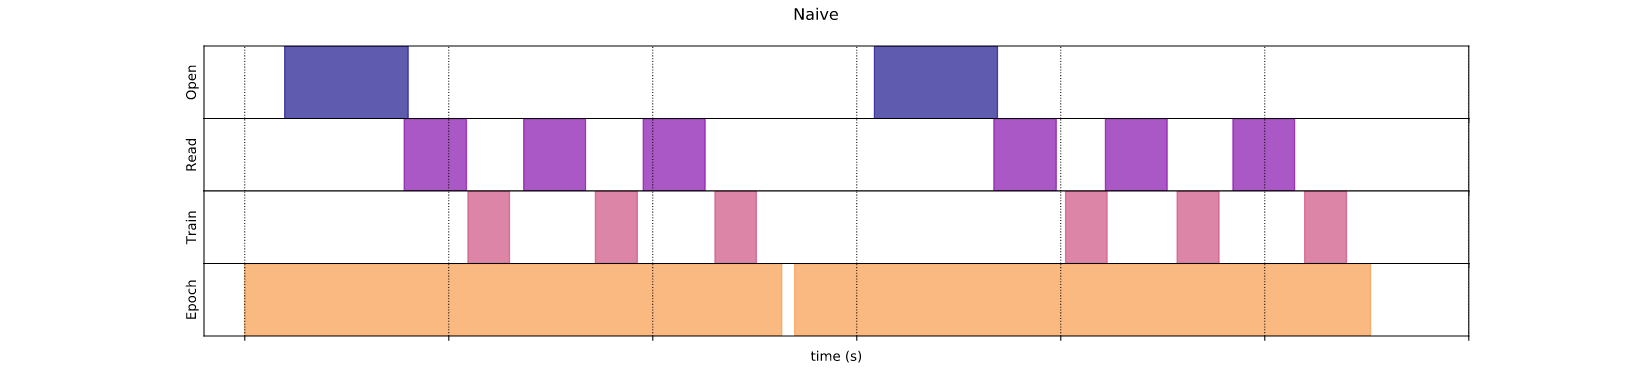

The plot shows that performing a training step involves:

    Opening a file if it hasn't been opened yet
    Fetching a data entry from the file
    Using the data for training

However, in a naive synchronous implementation like here, while your pipeline is fetching the data, your model is sitting idle. Conversely, while your model is training, the input pipeline is sitting idle. The training step time is thus the sum of opening, reading and training times.

## Prefetching
Prefetching solves the inefficiencies from naive approach as it aims to overlap the preprocessing and model execution of the training step. In other words, when the model is executing training step n, the input pipeline will be reading the data for step n+1.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested.

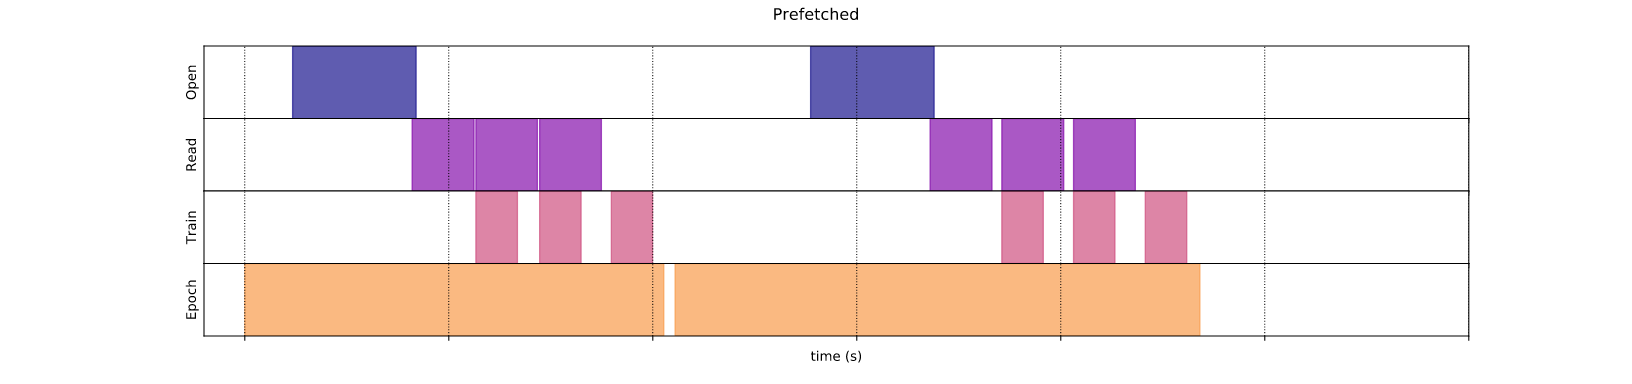

Now, as the data execution time plot shows, while the training step is running for sample 0, the input pipeline is reading the data for the sample 1, and so on.

## Caching
The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

One thing to note — you should cache after preprocessing (especially when these preprocessing functions are computational expensive) and before augmentation, as you would not want to store any randomness from your augmentations.

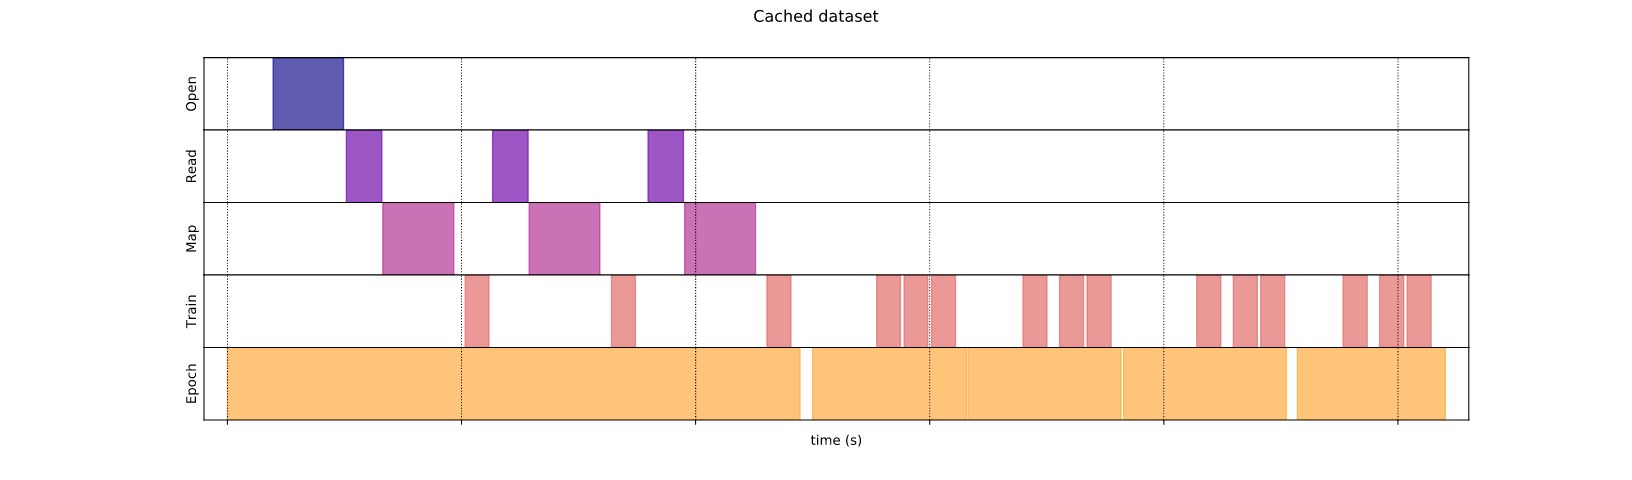

Here, the data execution time plot shows that when you cache a dataset, the transformations before the cache one (like the file opening and data reading) are executed only during the first epoch. The next epochs will reuse the data cached by thecache transformation.

In [21]:
import tensorflow as tf
import time

In [22]:
tf.__version__

'2.16.1'

## Prefetch

In [23]:
class FileDataset(tf.data.Dataset):
    def read_file_in_batches(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls.read_file_in_batches,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

In [24]:
def benchmark(dataset, num_epoch= 2):
    for epoc_num in range(num_epoch):
        for data in dataset:
            time.sleep(0.01)

In [25]:
%%timeit
benchmark(FileDataset())

2024-06-20 13:45:46.232169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:46.348600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:46.506654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:46.644639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:46.799585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:46.929120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:47.087334: W tensorflow/core/framework/local_rendezvous.cc:404] L

285 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2024-06-20 13:45:48.215841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:48.353429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
%%timeit
benchmark(FileDataset().prefetch(1)) # 1 is the epoch

2024-06-20 13:45:49.344504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:49.475142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:49.637928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:49.773724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:49.940881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:50.070562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:50.238149: W tensorflow/core/framework/local_rendezvous.cc:404] L

303 ms ± 7.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2024-06-20 13:45:51.470906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:45:51.610736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Without optimizing we have `295 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

With optimization `290 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

There is a gap around 5 ms per 

In [27]:
# Let's try using argument in prefetch

%%timeit
benchmark(FileDataset().prefetch(tf.data.AUTOTUNE))


UsageError: Line magic function `%%timeit` not found.


## Cache


In [32]:
dataset = tf.data.Dataset.range(5)

dataset = dataset.map(lambda x: x**2)
dataset = dataset.cache("mycache.txt")
dataset

<CacheDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [33]:
for data in dataset:
    print(data.numpy())

0
1
4
9
16


2024-06-20 13:53:55.328095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 13:53:55.328538: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [34]:
# Subsequent iterations read from the cache.
list(dataset.as_numpy_iterator())

2024-06-20 13:53:57.070529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0, 1, 4, 9, 16]

In [35]:
def mapped_function(s):
    # Doing some hard preprocessing
    tf.py_function(lambda: time.sleep(0.03),[],())
    return s

In [38]:
%%timeit -r1 -n1 # -r1 -n1 just run one loop

benchmark(FileDataset().map(mapped_function), 5) # 5 is the number of epoch

2024-06-20 14:00:24.357962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:24.583713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:24.868310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:25.137198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2024-06-20 14:00:25.410717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
%%timeit -r1 -n1 
benchmark(FileDataset().map(mapped_function).cache(), 5)

608 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2024-06-20 14:00:26.644619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:26.684762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:26.724700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:26.764022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 14:00:26.803336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
